In [1]:
# My libraries that I use

import numpy as np
import json
import matplotlib.pyplot as plt
from pylab import cm
from sklearn.decomposition import NMF
from scipy import ndimage,interpolate
from matplotlib.patches import Rectangle
from matplotlib import patheffects as pe
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

In [2]:
# My functions for loading data, need the .npy and .json exported directly from Swift (select Raw NumPy option)

def LoadEELS_SI(fname):
    """
    Loads an EEL Spectrum Image
    
    Input:  fname - path to either .npy or .json file that (string)
    Output: dat   - data (numpy array)
            cal   - pixel calibration in nm (float)
            disp  - energy dispersion in eV (float)
            mdat  - metadata (python dictionary)
    """    

    if fname.endswith('npy'): fname=fname[:-4]
    if fname.endswith('json'): fname=fname[:-5]
    dat=np.load(fname+'.npy')
    mdat= json.load(open(fname+'.json','r'))
    cal=mdat['spatial_calibrations'][0]['scale']
    disp=mdat['spatial_calibrations'][-1]['scale']
    return dat,cal,disp,mdat

def LoadImage(fname):
    """
    Loads a 2D STEM Image
    
    Input:  fname - path to either .npy or .json file that (string)
    Output: im    - image data (numpy array)
            cal   - pixel calibration in nm (float)
            mdat  - metadata (python dictionary)
    """    

    if fname.endswith('npy'): fname=fname[:-4]
    if fname.endswith('json'): fname=fname[:-5]
    dat=np.load(fname+'.npy')
    mdat= json.load(open(fname+'.json','r'))
    cal=mdat['spatial_calibrations'][0]['scale']
    return dat,cal,mdat

In [3]:
#Load HAADF data

filename='/Users/j6h/Analyses/Data/Me/PlasmonCoupling/Touching_Z.npy'
Z,Z_cal,Z_mdat=LoadImage(filename)

In [4]:
# Function to add a clean scale bar to images

def AddScaleBar(axis,scale,cal,w=None,xy=None,units='nm',fontsize=10,text=True):
    """
    Adds scale bar to an image in a subplot
    Input:    axis     - subplot axis for added scalebar (matplotlib axis)
              scale    - desired length of scalebar in desired unit (int)
              cal      - calibration of image in desired units/pixel (float)
    Optional: w        - width of scale bar in pixels (float) Default: 1/50th of image height
              xy       - coordinates of top left corner of scale bar (tuple) NOTE: coordinates of bar not text
                          Default: None (puts bar w pixels in each dimension away from bottom left corner)
              units    - desired units (str) Default: 'nm'
              fontsize - size of font (float) Default: 8
              text     - Display actual text of scale bar (bool) Default: True
    Output: fig - displayed image (matplotlib figure)
    """   
    imdim=axis.get_images()[0].get_extent()
    dim=[int(imdim[2]-imdim[3]),int(imdim[1]-imdim[-0])]
    if not w: w=dim[0]/50.
    if not xy: xy=(w,dim[0]-2*w)
    axis.add_patch(Rectangle(xy,scale/cal,w,fc='w',ec='k',lw=0.5))
    if text: 
        txt=axis.text(xy[0]+0.5*scale/cal,xy[1],str(scale)+' '+units,fontweight='bold',color='w',fontsize=fontsize,ha='center',va='bottom')
        txt.set_path_effects([pe.withStroke(linewidth=1,foreground='k')])
    return

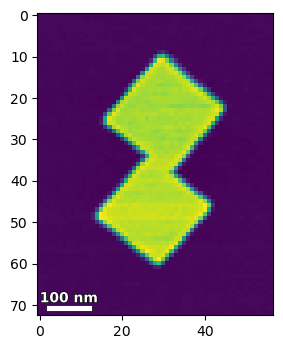

In [5]:
# Display HAADF

scale=100
f,a=plt.subplots(1,1,dpi=100)
a.imshow(Z)
AddScaleBar(a,scale,Z_cal)

In [6]:
# Load SI data

filename='/Users/j6h/Analyses/Data/Me/PlasmonCoupling/Touching_SI.npy'
dat,cal,disp,mdat=LoadEELS_SI(filename)

In [7]:
# Functions to calibrate spectrum image

def GetSIEnergyAxes(dat,disp,style='fwhm',subpix_w=30):
    """
    Creates a numpy array of calibrated energy loss axes calibrated to individual spectra in SI
    
    Input:    dat      - data (numpy array)
              disp     - energy dispersion in eV (float)
              style    - 'pixel': calibrates to pixel with max intensity of ZLP
                         'fwhm': calibrates to center of fwhm of ZLP (Default)
                         'subpixel': fits gaussian to a number of pixels around the ZLP (w pixels)
    Optional: subpix_w - Number of pixels for sub-pixel ZLP fit (Default = 30)
    Output:   ens      - calibrated energy axes (numpy array)
    """   
    
    E_init=np.arange(0,dat.shape[-1])*disp
    w=int(subpix_w/2.)
    if style=='pixel':
        centers=np.array([[E_init[np.argmax(s)] for s in row] for row in dat])
    if style=='fwhm':
        centers=np.asarray([[np.average(Get_FWHM(E_init,s)[:2]) for s in row] for row in dat])
    if style=='subpixel':
        centers=np.array([[optimize.curve_fit(gauss,E_init[np.argmax(s)-w:np.argmax(s)+w],
                s[np.argmax(s)-w:np.argmax(s)+w]/np.amax(s))[0][1] for s in row] for row in dat])
    ens=np.array([[E_init-c for c in row] for row in centers])
    return ens

def GetCalibratedSI(dat,ens,en_lo=None,en_hi=None,n_int=None):
    """
    Creates new interpolated energy-loss axis to which all spectra in the SI are aligned
    
    Input:    dat   - data (numpy array)
              ens   - calibrated energy axes (numpy array)
    Optional: en_lo  - desired lowest energy of the output data (float)
                        Default: None (finds highest minimum energy available for all spectra)
              en_hi  - desired highest energy of cropped data (float)
                        Default: None (finds lowest maximum energy available for all spectra)
              n_int - Number of data points for interpolated axis (int)
                        Default: None (chooses number to be closest to as-acquired dispersion)
    Output:   E     - calibrated energy axis (numpy array)
              SI    - calibrated spectrum image (numpy array)
    """   
    
    m=np.amax(ens[:,:,0]);M=np.amin(ens[:,:,-1])  
    dispersion=ens[0,0,1]-ens[0,0,0]
    if not en_lo or en_lo<m: en_lo=m
    if not en_hi or en_hi>M: en_hi=M
    if not n_int: n_int=int((en_hi-en_lo)/dispersion)
    E=np.linspace(en_lo,en_hi,n_int)
    dim=ens.shape
    SI=np.zeros((*dim[:2],n_int))
    for i in range(dim[0]):
        for j in range(dim[1]):
            k1=Get_i(ens[i,j],en_lo);k2=Get_i(ens[i,j],en_hi)
            fSI=interpolate.interp1d(ens[i,j],dat[i,j],kind='linear')
            SI[i,j]=fSI(E)
    return E,SI

# Functions to facilitate easy analysis (also needed for SI calibration)

def NormArray(arr):
    """
    Converts an array of arbitrary values to a 0-1 range
    
    Input:  arr  - numpy array
    Output: narr - normalized numpy array
    """    
    
    arr = np.asarray(arr)
    M=np.amax(arr);m=np.amin(arr)
    narr = (arr-m)/(M-m)
    return narr

def Get_i(arr,val):
    """
    Gives index of array closest to desired value
    
    Input:  arr - numpy array
            val - float
    Output: i   - index of closest value to desired float (int)
    """    
    
    i=np.argmin(np.abs(arr-val))
    return i

def Get_FWHM(en,spec,interp=False):
    """
    Finds FWHM of ZLP and returns half-maxes and width in energy
    
    Input:  en    - energy loss axis (numpy array)
            spec  - EELS axis (numpy array)
    Output: en_lo - energy of lower half max in eV (float)
            en_hi - energy of upper half max in eV (float)
            en_w  - FWHM of ZLP in eV (float)
    """    
    
    s=NormArray(spec)
    i_lo=Get_i(s[:np.argmax(s)],0.5)
    i_hi=Get_i(s[np.argmax(s):],0.5)+np.argmax(s)
    if interp:
        #disp=en[1]-en[0];disp_i=disp/100.
        #en_lo_fit=np.arange(en[i_lo-1:i_lo+1],disp_i);en_hi_fit=np.arange(en[i_hi-1:i_hi+1],disp_i)
        f_lo=interpolate.interp1d(s[i_lo-1:i_lo+2],en[i_lo-1:i_lo+2])
        f_hi=interpolate.interp1d(s[i_hi-1:i_hi+2],en[i_hi-1:i_hi+2])
        print(i_lo,i_hi)
        en_lo=f_lo(0.5);en_hi=f_hi(0.5)
    else: en_lo=en[i_lo];en_hi=en[i_hi]
    en_w=en_hi-en_lo
    return en_lo,en_hi,en_w

In [8]:
# Generate calibrated energy axes for each spectrum in spectrum image

ens=GetSIEnergyAxes(dat,disp)

# Generate calibrated spectrum image single calibrated energy axis

E,SI=GetCalibratedSI(dat,ens)

Text(0.5, 1.0, 'ZLP (Calibrated)')

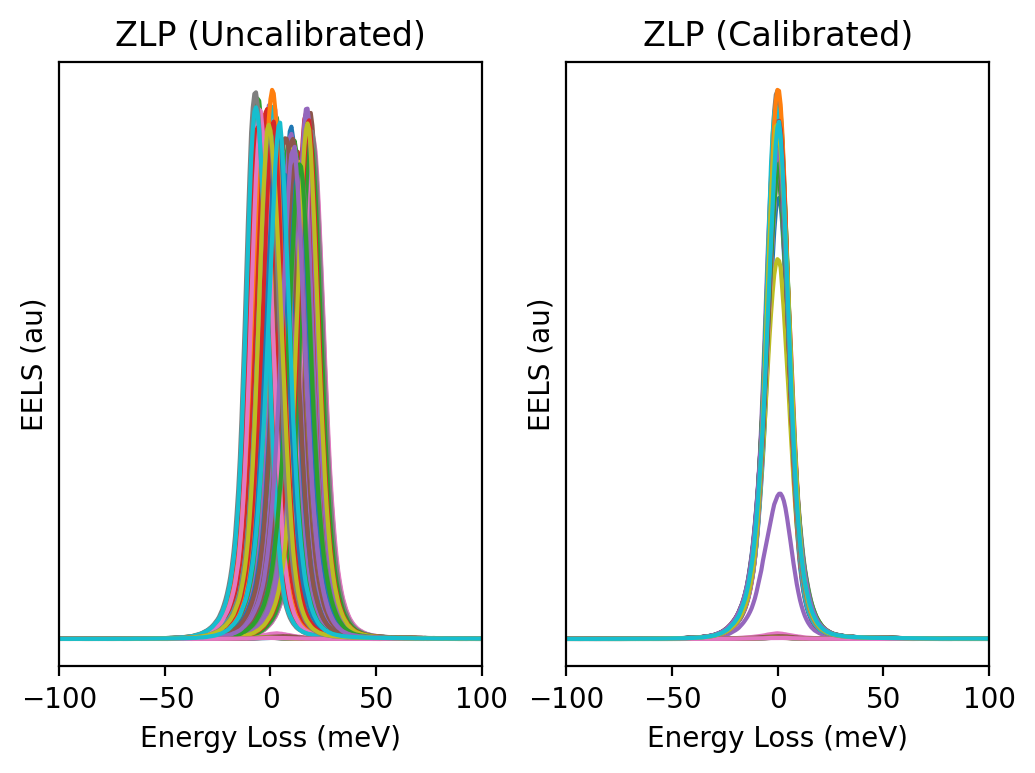

In [9]:
#Check to see if calibration worked sensibly.

f,a=plt.subplots(1,2,dpi=200)
plt.setp(a,yticks=[],ylabel='EELS (au)',xlabel='Energy Loss (meV)',xlim=(-100,100))

#Generate energy axis for uncalibrated dataset
E_uncalibrated=(np.arange(dat.shape[2])-np.argmax(np.average(dat,axis=(0,1))))*disp

#Grab 100 random spectra from the spectrum image
for N in range(100):
    i=np.random.randint(SI.shape[0])
    j=np.random.randint(SI.shape[1])
    a[0].plot(E_uncalibrated*1000,dat[i,j])
    a[1].plot(E*1000,SI[i,j])

a[0].set_title('ZLP (Uncalibrated)')
a[1].set_title('ZLP (Calibrated)')

In [10]:
# Function to help visualize spectrum image

def SI_Analyzer(E,SI,En,En_W,Regions,R_W,visualize=True,Colors=None,cmap=None,xlim=None,ylim=None,yscale='linear'):
    """
    Takes a spectrum image and outputs an SI slice and a series of representative spectra from selectable energy ranges and locations
    
    Input:    E        - energy axis of EEL spectrum (numpy array)
              SI       - 3D EEL spectrum image (numpy array)
              En       - energy center of the SI slice (float)
              En_W     - energy width of the SI slice (float)
              Regions  - list of y,x coordinates (in pixels) for upper left corner for representative spectra location (list of integer tuples)
              R_W      - number of integrated pixels in each dimension for representative spectra (int)
    Optional: viualize - Plot output (boolean): Default - True
              Colors   - customized list of colors for representative spectra (list of fractional RGB values, i.e. [(1.0, 0., 0.)])
              cmap     - custom color map for SI Slice: Default - cm.inferno
              xlim     - customized x limits of representative spectra plot
              ylim     - customized y limits of representative spectra plot 
              yscale   - y scale of representative spectra plot: Default - 'linear' (can be 'log')
    Output:   E_out    - energy axis of the fitted region (numpy array)
              BG_out   - background intensity in fitted region (numpy array)
              S_out    - EELS intensity in fitted region (numpy array)    
    """       
    Specs=[np.average(SI[R[0]:R[0]+R_W,R[1]:R[1]+R_W],axis=(0,1)) for R in Regions]
    Slice=np.average(SI[:,:,Get_i(E,En-En_W/2.):Get_i(E,En+En_W/2.)],axis=2)
    if visualize:
        if not Colors: Colors=[plt.get_cmap("tab10")(i) for i in range(len(Regions))]
        if not cmap: cmap=cm.inferno
        f,a=plt.subplots(1,2,figsize=(9,3),dpi=200)
        cb=a[0].imshow(Slice,cmap=cmap)
        for R,S,C in zip(Regions,Specs,Colors):
            a[0].add_patch(Rectangle((R[1]-0.5,R[0]-0.5),R_W,R_W,fc='none',ec='k',lw=2.5))
            a[0].add_patch(Rectangle((R[1]-0.5,R[0]-0.5),R_W,R_W,fc='none',ec=C,lw=1.25))
            a[1].plot(E,S,color=C,lw=0.5)

        plt.setp(a[0],xticks=[],yticks=[])
        xy=a[0].get_position()
        cbax=f.add_axes([xy.x0,xy.y0-0.05,xy.width,0.03])
        plt.colorbar(cb,cax=cbax,orientation='horizontal')
        cbax.set_xlabel('Slice Intensity (Counts)')

        plt.setp(a[1],xlabel='Energy Loss (eV)',ylabel='Intensity (counts)')
        ym,yM=a[1].get_ylim()
        a[1].fill_betweenx([ym,yM],E[Get_i(E,En-En_W/2.)],E[Get_i(E,En+En_W/2.)],color=cmap(0.5),alpha=0.3,lw=0)
        if xlim: a[1].set_xlim(xlim[0],xlim[1])
        if ylim: a[1].set_ylim(ylim[0],ylim[1])
        else: a[1].set_ylim(ym,yM)
        a[1].set_yscale(yscale)
        
    return Specs,Slice


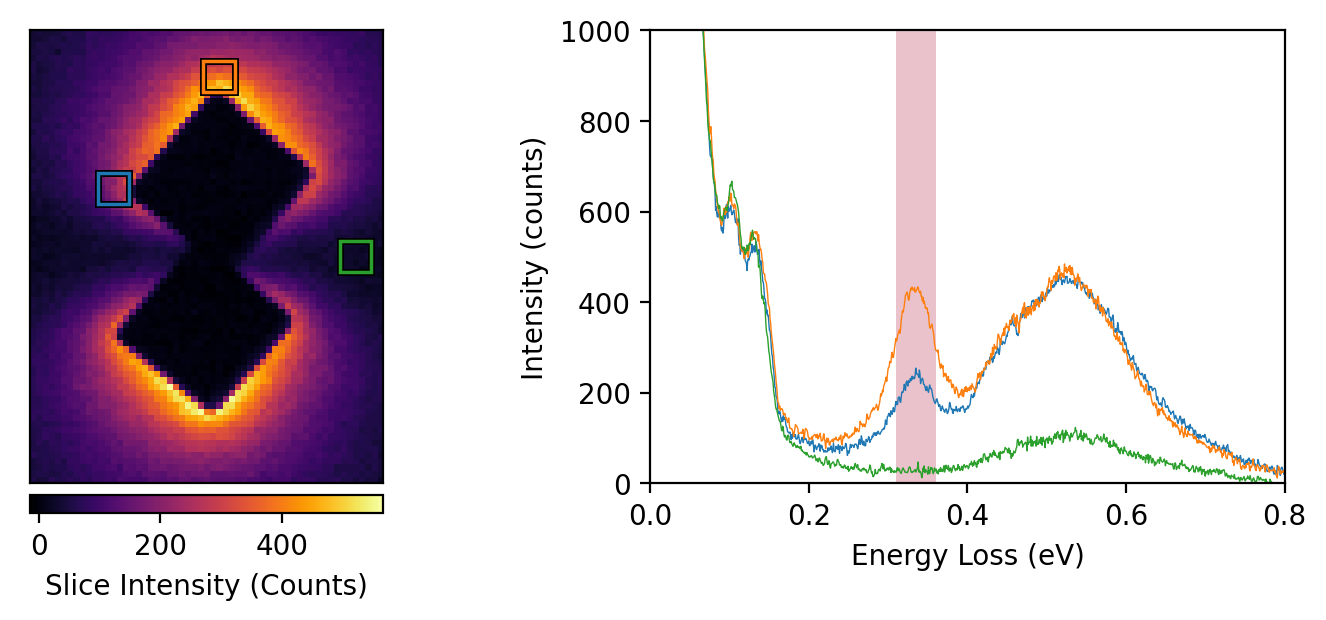

In [11]:
SI_Specs,SI_Slice=SI_Analyzer(E,SI,0.335,0.05,[[23,11],[5,28],[34,50]],5,xlim=(0,0.8),ylim=(0,1000))

In [12]:
### Create new color maps for better NMF visualization

Purple=150./255,50/255., 1.
Orange=1,120./255, 0
Blue=10./255,175/255., 1.
Red=200./255,20/255., 20/225.
Green=30./255,200./255, 30./255
Yellow=220./255,220./255, 90./255
Pink=255/255.,105/255., 180/255.
Gold=155/255.,205/255.,32/255.
Turquoise=72/255., 229/255., 204/255.
Brown=220/255., 142/255., 105/255.
Forest=64/255., 169/255., 64/255.
Gray=159/255., 176/255., 184/255.
Royal=95/255., 55/255., 255/255.

colors=[Blue,Red,Green,Purple,Orange,Yellow,Pink,Gray,Royal,Turquoise,Gold,Forest,Brown]

bBw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Blue   ,(1,1,1)], N=100)
bRw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Red    ,(1,1,1)], N=100)
bGw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Green  ,(1,1,1)], N=100)
bPw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Purple ,(1,1,1)], N=100)
bOw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Orange ,(1,1,1)], N=100)
bYw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Yellow ,(1,1,1)], N=100)
bPiw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Pink ,(1,1,1)], N=100)
bGrw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Gray ,(1,1,1)], N=100)
bRow = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Royal ,(1,1,1)], N=100)
bGow = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Gold ,(1,1,1)], N=100)
bTuw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Turquoise ,(1,1,1)], N=100)
bBrw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Brown ,(1,1,1)], N=100)
bFow = LinearSegmentedColormap.from_list('list', [(0, 0, 0), Forest ,(1,1,1)], N=100)


colormaps=[bBw,bRw,bGw,bPw,bOw,bYw,bPiw,bGrw,bRow,bTuw,bGow,bBrw,bFow]


/Users/j6h/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


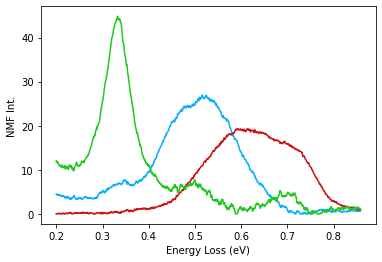

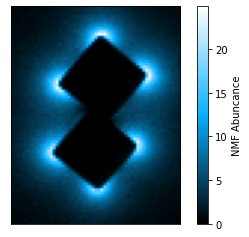

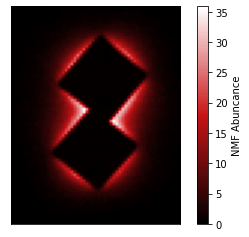

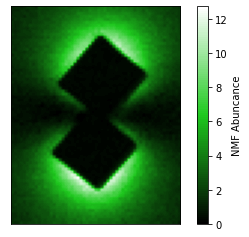

In [13]:
# Perform NMF on calibrated Dataset

# Define dataset to work on (important if you have multiple in the same notebook)
use_E=np.copy(E)
use_SI=np.copy(SI)

# Define low and high energy cutoff (NMF works best if only the spectral range your interested is analyzed)
Ecut_l=0.2
Ecut_h=1.
i_l=Get_i(use_E,Ecut_l)
i_h=Get_i(use_E,Ecut_h)
Enmf=use_E[i_l:i_h]
NMFdat=use_SI[:,:,i_l:i_h]

# Convert Spatial Axis to 1D array
NMFdat_flat=NMFdat.reshape((np.prod(use_SI.shape[:2]),i_h-i_l))

# Zero all negative datapoints
NMFdat_flat[np.where(NMFdat_flat<0)]=0

# Select Number of NMF Components
N=3

# Call NMF
model=NMF(n_components=N,max_iter=10000)
NMFMaps=model.fit_transform(NMFdat_flat)
NMFSpec=model.components_
NMFMaps=NMFMaps.reshape((SI.shape[0],SI.shape[1],N)).transpose(2,0,1)

# Visualize NMF Results

for i in range(N): plt.plot(Enmf,NMFSpec[i],c=colors[i])
plt.xlabel('Energy Loss (eV)')
plt.ylabel('NMF Int.')
plt.show()
for i in range(N): 
    f,a=plt.subplots(1,1)
    plt.setp(a,xticks=[],yticks=[])
    cb=a.imshow(NMFMaps[i],cmap=colormaps[i],vmin=0)
    plt.colorbar(cb,ax=a,label='NMF Abuncance')
    plt.show()

/Users/j6h/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


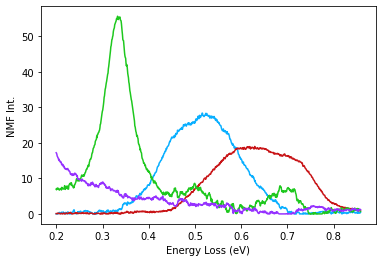

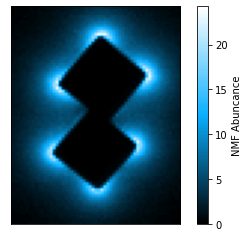

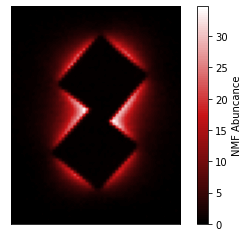

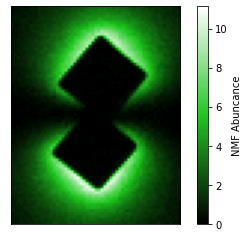

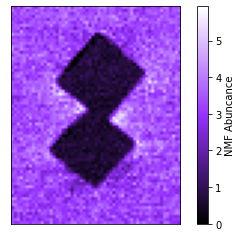

In [14]:
# Try Varying the Number of Components

# Define dataset to work on (important if you have multiple in the same notebook)
use_E=np.copy(E)
use_SI=np.copy(SI)

# Define low and high energy cutoff (NMF works best if only the spectral range your interested is analyzed)
Ecut_l=0.2
Ecut_h=1.
i_l=Get_i(use_E,Ecut_l)
i_h=Get_i(use_E,Ecut_h)
Enmf=use_E[i_l:i_h]
NMFdat=use_SI[:,:,i_l:i_h]

# Convert Spatial Axis to 1D array
NMFdat_flat=NMFdat.reshape((np.prod(use_SI.shape[:2]),i_h-i_l))

# Zero all negative datapoints
NMFdat_flat[np.where(NMFdat_flat<0)]=0

# Select Number of NMF Components
N=4

# Call NMF
model=NMF(n_components=N,max_iter=10000)
NMFMaps=model.fit_transform(NMFdat_flat)
NMFSpec=model.components_
NMFMaps=NMFMaps.reshape((SI.shape[0],SI.shape[1],N)).transpose(2,0,1)

# Visualize NMF Results

for i in range(N): plt.plot(Enmf,NMFSpec[i],c=colors[i])
plt.xlabel('Energy Loss (eV)')
plt.ylabel('NMF Int.')
plt.show()
for i in range(N): 
    f,a=plt.subplots(1,1)
    plt.setp(a,xticks=[],yticks=[])
    cb=a.imshow(NMFMaps[i],cmap=colormaps[i],vmin=0)
    plt.colorbar(cb,ax=a,label='NMF Abuncance')
    plt.show()

/Users/j6h/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


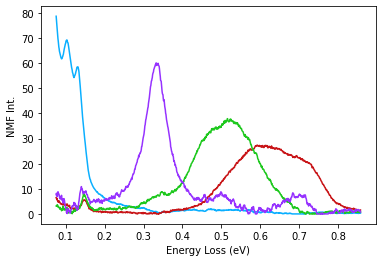

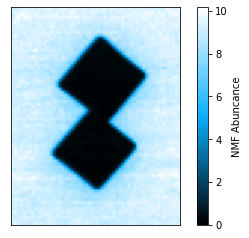

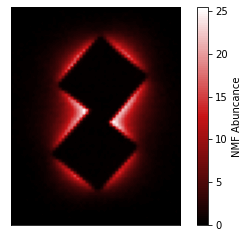

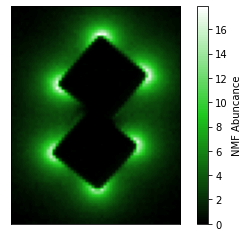

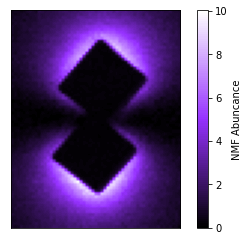

In [15]:
# Try Varying the Energy Range

# Define dataset to work on (important if you have multiple in the same notebook)
use_E=np.copy(E)
use_SI=np.copy(SI)

# Define low and high energy cutoff (NMF works best if only the spectral range your interested is analyzed)
Ecut_l=0.075
Ecut_h=1.
i_l=Get_i(use_E,Ecut_l)
i_h=Get_i(use_E,Ecut_h)
Enmf=use_E[i_l:i_h]
NMFdat=use_SI[:,:,i_l:i_h]

# Convert Spatial Axis to 1D array
NMFdat_flat=NMFdat.reshape((np.prod(use_SI.shape[:2]),i_h-i_l))

# Zero all negative datapoints
NMFdat_flat[np.where(NMFdat_flat<0)]=0

# Select Number of NMF Components
N=4

# Call NMF
model=NMF(n_components=N,max_iter=10000)
NMFMaps=model.fit_transform(NMFdat_flat)
NMFSpec=model.components_
NMFMaps=NMFMaps.reshape((SI.shape[0],SI.shape[1],N)).transpose(2,0,1)

# Visualize NMF Results

for i in range(N): plt.plot(Enmf,NMFSpec[i],c=colors[i])
plt.xlabel('Energy Loss (eV)')
plt.ylabel('NMF Int.')
plt.show()
for i in range(N): 
    f,a=plt.subplots(1,1)
    plt.setp(a,xticks=[],yticks=[])
    cb=a.imshow(NMFMaps[i],cmap=colormaps[i],vmin=0)
    plt.colorbar(cb,ax=a,label='NMF Abuncance')
    plt.show()